In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.ticker as ticker
import scipy
from scipy.optimize import curve_fit

First thing I did was decompress the rent data so that it could be chunked into smaller sizes.
I initially split it in my local system but found that the extra text through off the columns, so I am using
pandas chunk feature. 

In [2]:
reader = pd.read_csv('renthub_data.csv', usecols = [0, 3, 9, 12], iterator=True, dtype = {0:'int'}) #unzipped file, id, zip, price, posted_at cols
df = reader.get_chunk(4000) #first 4000 lines

In [3]:
df2 = reader.get_chunk(10000) #smaller subset used for testing. 10,000 listings for these tests
df2['posted_at'] = pd.to_datetime(df2['posted_at']) #convert to datetime format
#df2 = df2[::50] #split even smaller if necessary, while keeping a range of listing dates.
df2.reset_index(inplace = True, drop = True)

In [4]:
#INTRO GOAL 1: Mulitple listings removed. Done below
#INTRO GOAL 3: only have relevant data read in. This was done at time of creating dataframe
df2.drop_duplicates(subset = ['id'], inplace = True) #drop duplicates by id. could transfer this to another column
df2.reset_index(inplace = True, drop = True)


In [5]:
#add columns for date without seconds, ms. and column with just month
new_dates = []
new_months = []
for i in range(len(df2)):
    cdate = df2['posted_at'][i]
    new_dates.append(cdate.strftime("%Y") + '-' + cdate.strftime("%m") + '-' + cdate.strftime("%d"))
    new_months.append(cdate.strftime("%m"))
df2['date'] = new_dates
df2['month'] = new_months


In [6]:
df2['month'] = df2['month'].astype(int)

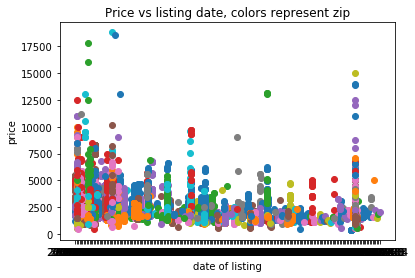

In [7]:
#graph of all listings and their prices, separated into zip codes. 
#I would not run this graph if the chunksize was much larger
groups = df2.groupby("zip")
for name, group in groups:
    plt.plot(group["date"], group["price"], marker="o", linestyle="", label=name)
plt.xlabel('date of listing')
plt.ylabel('price')
plt.title('Price vs listing date, colors represent zip')
plt.show()
#plt.legend()

This is a bit unwieldy, since dates are unreadable in Year-month-day format. Lets switch to monthly view

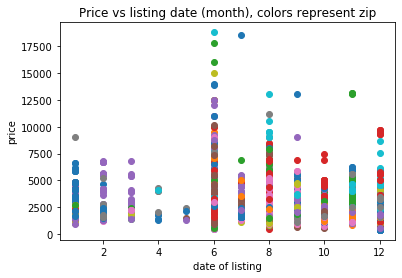

In [8]:
groups = df2.groupby("zip")
for name, group in groups:
    plt.plot(group["month"], group["price"], marker="o", linestyle="", label=name)
plt.xlabel('date of listing')
plt.ylabel('price')
plt.title('Price vs listing date (month), colors represent zip')
plt.show()

Can see general trend. Prices fall off until June, another smaller peak in August. Looks like there might be some outliers,
especially at July/November

Other notes: April and May don't have very may data points. This is a smaller sample but would keep an eye on that. 

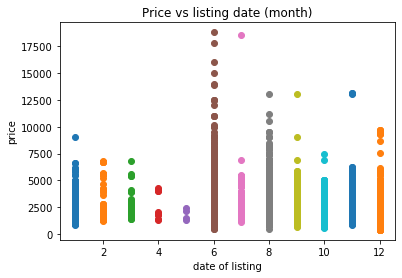

In [9]:
groups = df2.groupby("month")
for name, group in groups:
    plt.plot(group["month"], group["price"], marker="o", linestyle="", label = group['zip'])
plt.xlabel('date of listing')
plt.ylabel('price')
plt.title('Price vs listing date (month)')
#plt.legend()
plt.show()


In [10]:
print('number of listings by month')
df2.month.value_counts()

number of listings by month


6     2779
8     2593
9     1067
1      990
10     844
11     788
12     593
7      181
2       90
3       61
4       10
5        4
Name: month, dtype: int64

In [11]:
print(f'May has {df2.month.value_counts()[5]} properties')
print(f'April has {df2.month.value_counts()[4]} properties')

May has 4 properties
April has 10 properties


Can see that there is a clear discrepancy in listings by month. I would investigate this further in the full dataset.
Currently I would not run statistics on just April or May. 

Text(0.5, 1.0, 'listings numbers by month')

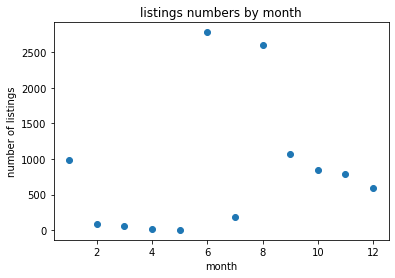

In [12]:
plt.scatter(df2.month.value_counts().index, y = df2.month.value_counts())
plt.xlabel('month')
plt.ylabel('number of listings')
plt.title('listings numbers by month')

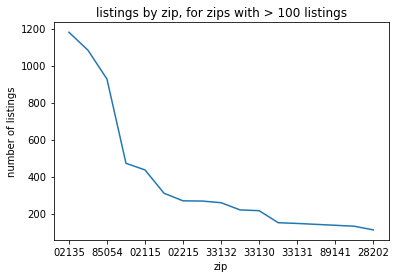

In [13]:
#graph of just those zips with more than 100 listings. 
#modified x axis to show only a few zip codes. 
y = df2.zip.value_counts()
yi = y[y > 100]

tick_spacing = 2
fig, ax = plt.subplots(1,1)

ax.plot(yi)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlabel('zip')
plt.ylabel('number of listings')
plt.title('listings by zip, for zips with > 100 listings')
plt.show()

In [14]:
t = set(df2['zip']) & set(pd.DataFrame(yi).index)
df_sub1 = df2[df2['zip'].isin(t)]

df_sub1 is dataframe of all listings who belong to a zip code with more than 100 listings, in my 10,000 subsample

In [15]:
print(f'Number of zip codes before cutoff {y.sum()}, Number of zip codes after cutoff {yi.sum()}')

Number of zip codes before cutoff 9891, Number of zip codes after cutoff 6461


In [16]:
y2 = y[y>10]
y2

02135    1180
02134    1083
85054     927
60654     472
02115     436
         ... 
84070      11
89011      11
60625      11
33140      11
02120      11
Name: zip, Length: 106, dtype: int64

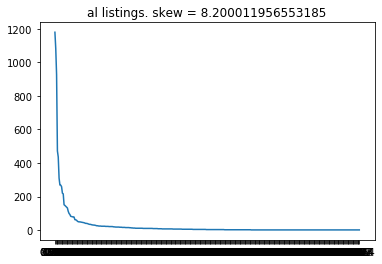

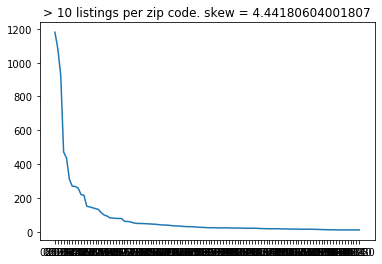

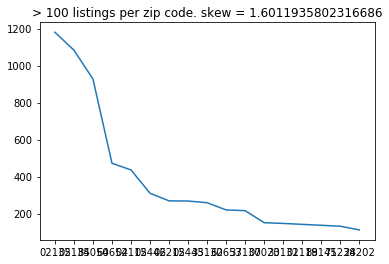

even at 10 cutoff data is still heavily skewed. Will choose 100 listings at the cutoff based on this


In [17]:
plt.plot(y)
plt.title(f'al listings. skew = {y.skew()}')
plt.show()
plt.plot(y2)
plt.title(f'> 10 listings per zip code. skew = {y2.skew()}')
plt.show()
plt.plot(yi)
plt.title(f'> 100 listings per zip code. skew = {yi.skew()}')
plt.show()
print('even at 10 cutoff data is still heavily skewed. Will choose 100 listings at the cutoff based on this')

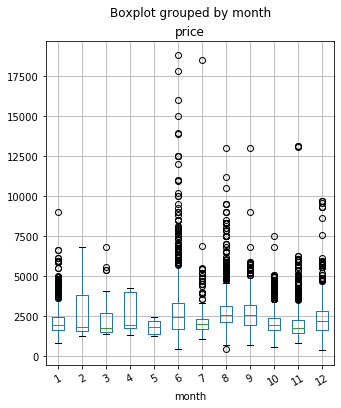

In [18]:
df2.boxplot('price','month',rot = 30,figsize=(5,6))

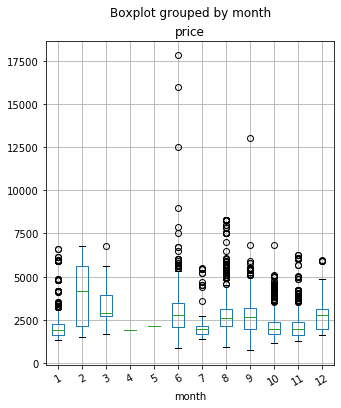

In [19]:
df_sub1.boxplot('price','month',rot = 30,figsize=(5,6))

In [20]:
x = np.linspace(int(yi.index.min()), int(yi.index.max()), len(yi))

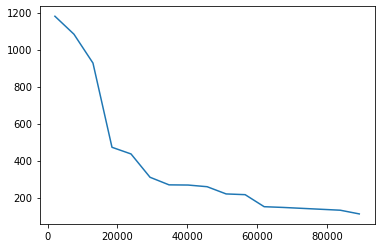

In [21]:
plt.plot(x, yi)

In [22]:
print(f' mean of this subset of prices is {np.mean(yi)}, \n variance is {np.var(yi)}')

 mean of this subset of prices is 380.05882352941177, 
 variance is 111627.70242214538


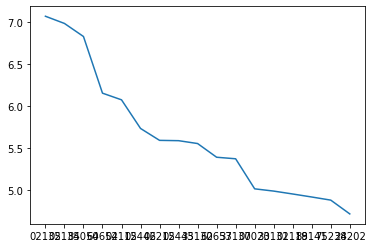

In [23]:
plt.plot(np.log(yi))

In [24]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

R² = 0.9604558962320475
Y = 1298.5161950523902 * e^(-5.363440406597942e-05 * x) + 112.44368087796227


<ipython-input-24-ae8712dc3d73>:2: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-t * x) + b


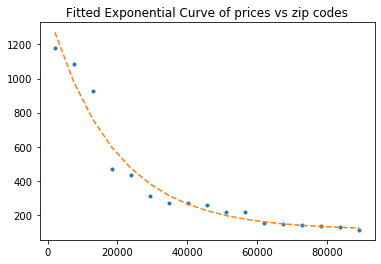

In [25]:
xs = x.copy()
ys = yi.copy()
p0 = (4, .0001, 75) # guesses
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
m, t, b = params
sampleRate = 20_000 # Hz
tauSec = (1 / t) / sampleRate

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# plot the results
plt.plot(xs, ys, '.', label="data")
plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted")
plt.title("Fitted Exponential Curve of prices vs zip codes")

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}")

In [26]:
print('mean and std. deviation of fitted data')
print(np.mean(monoExp(xs, m, t, b)), np.var(monoExp(xs, m, t, b)))

mean and std. deviation of fitted data
380.05882326237526 107213.4853381993


I am going to choose one of the zip codes (28202) which has a decent number of listings, but a scarcity for some months
I will run some analysis on this as a test case

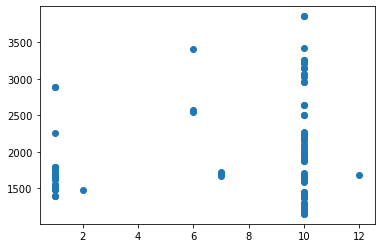

In [27]:
plt.scatter(df2[df2['zip'] == '28202']['month'], df2[df2['zip'] == '28202']['price'])

Can tell that several months are missing data or have much less, compared to January and October

In [28]:
df_subset2 = df2[df2['zip'] == '28202'] #only this zip code

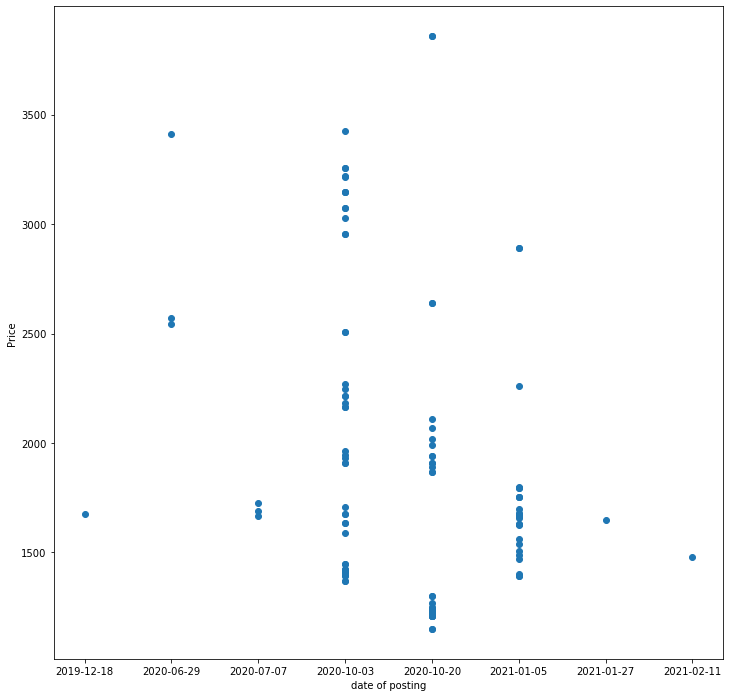

Looking at this brings up the interesting idea of changes in year. 2020 may have been a bad rental year for this zip code, things pick up at the end of the year and into the next. Would investigate further if that was of interest


In [29]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.scatter(df_subset2['date'], df_subset2['price'])
plt.xlabel('date of posting')
plt.ylabel('Price')
plt.show()
print('Looking at this brings up the interesting idea of changes in year. 2020 may have been a bad rental year \
for this zip code, things pick up at the end of the year and into the next. Would investigate further if that was of interest')

In [30]:
print('Rent prices peaking around October, large quantity but lesser price in January of next year')

Rent prices peaking around October, large quantity but lesser price in January of next year


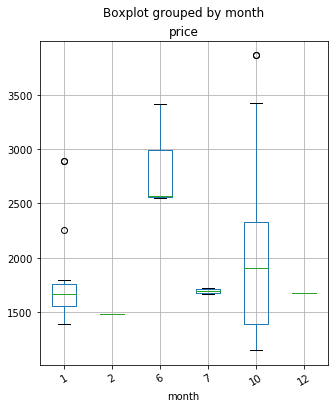

In [31]:
df_subset2.boxplot('price','month',rot = 30,figsize=(5,6))

In [32]:
print(df_subset2['price'].describe())
print('Descriptive statistics of the data for this zip code for months with > 10 listings')

count     112.000000
mean     1939.392857
std       665.256360
min      1149.000000
25%      1424.750000
50%      1703.000000
75%      2213.000000
max      3859.000000
Name: price, dtype: float64
Descriptive statistics of the data for this zip code for months with > 10 listings


In [33]:
df_subset3 = df_subset2.groupby('month').filter(lambda x: len(x) > 10) #df_subset3 is the data of subset2 that eliminates months with 
#less than 10 listings

This is the procedure I would apply for all the data:
1. Read in through pandas. Use chunksize if I am searching for a specific pattern or building models, this would be the training data.
2. Get rid of duplicates as done above, and cut off all zip codes that had less than 100 listings.

2a. addendum: Could also use a statistical method to find cutoff. If this was desired, I would cut off listings less than 10,
then cut off listings that fall further than 3 standard deviations from the mean. I did not do that here because the skew was so heavy in this chunksize visual inspection seemed sufficient

3. for meta analysis of all the data I would do as done above: group into zip codes, separate by month, and look for patterns.
Also fit the data to various models. This set had a negative exponential fit. 

4. For deeper analysis of a specific region, I would take from the subset only those relating to that zip code. Then I would run a pass on this data that removes months with missing or limited data. Then run whatever analysis we cared about for that region ('peak prices, variance, etc.')

4a. addendum: in this subset it was a clear cut off for months without enough data, and a simple pandas expression cut those off. In the larger dataset, I would not be able to as easily visually say "cut off at 10 listings". Instead I would cut months that had no data or very small data, then run another cut over months that had were several sigma away from standard. 



In [49]:
df_subset2['month'].value_counts().mean(), 'mean', df_subset2['month'].value_counts()

(18.666666666666668,
 'mean',
 10    76
 1     28
 6      3
 7      3
 2      1
 12     1
 Name: month, dtype: int64)

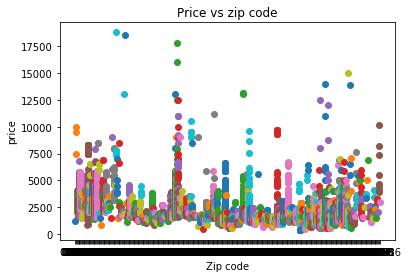

In [34]:
#zip codes are arranged from lowest to highest. Colors represent month.
groups = df2.groupby("zip")
for name, group in groups:
    plt.plot(group["zip"], group["price"], marker="o", linestyle="", label = group['month'])
plt.xlabel('Zip code')
plt.ylabel('price')
plt.title('Price vs zip code')
#plt.legend()
plt.show()